# Analyse BMF motif models from HT-SELEX dataset (Figure 2A-F, S3-5)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import os
from os.path import isfile, join
from itertools import compress
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.backends.backend_pdf
from scipy.stats import nbinom, sem, t, pearsonr
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import random
import statsmodels.api as sm

## helper functions

In [2]:
def generate_kmer_inx(l = 3):
    vals = {'A':0,'C':1,'G':2,'U':3}
    kmer_inx = {}
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

In [3]:
#reads the np.array files and extract the parameters
#the distance parameters (last 3) are exp'ed to stay positive
def read_params(files):
    n_additional = 1 #non parameters saved at the end
    n_exped = 3 #parameters kept positive through log exp trick
    params = []
    for f in files:
        param = np.loadtxt(join(param_dir, f))
        param[-n_additional-n_exped:-n_additional] = np.exp(param[-n_additional-n_exped:-n_additional])
        param[-n_additional-1] = param[-n_additional-1]/(1+param[-n_additional-1])
        params.append(param)      
    return params

## plotting functions

In [4]:
def plot_core_logo(data, ax, color_scheme):
    '''
    plots individual sequence logos in the given axis
    '''
    
    k=len(data[0][0])
    scalings = [d[1] for d in data]
    total = 1
    font_prop = matplotlib.font_manager.FontProperties(family="sans-serif", weight="bold")

    letter_heights = {}
    letter_widths = {}
    for l in "ACGTU":
        lp = matplotlib.textpath.TextPath((0,0), l, size=20, prop=font_prop)
        ext = lp.get_extents()
        letter_heights[l] = ext.y1 - ext.y0
        letter_widths[l] = ext.x1 - ext.x0
    max_letter_height = max(letter_heights.values())
    max_letter_width = max(letter_widths.values())

    letter_scalings = {k:max_letter_height/v for k,v in letter_heights.items()}

    indiv_yscaling = {}
    paths = []
    for kmer, scaling in data:
        row = []
        for letter in kmer:
            txt = matplotlib.textpath.TextPath((0,0), letter, size=20, prop=font_prop)
            txt._letter = letter
            row.append(txt)
        paths.append(row)

    scaled_height = total * max_letter_height

    transformed_paths = []
    cur_top = 0
    row_no = 0
    for row_paths, scaling in zip(paths, scalings):
        row_no += 1
        cur_x = 0
        for i, path in enumerate(row_paths): 
            sy = scaling/scaled_height * letter_scalings[path._letter]
            sx = 0.03
            path_t = path.transformed(matplotlib.transforms.Affine2D().scale(sx=sx, sy=sy).translate(tx=cur_x, ty=cur_top))
            path_t._letter = path._letter
            transformed_paths.append(path_t)
            ext = path_t.get_extents()
            cur_x += max_letter_width*sx#(ext.x1 - ext.x0)* 1.1
        
        if False: #row_no%2 == 0:
            x0 = 0
            x1 = cur_x
            y0 = cur_top
            y1 = cur_top + ext.y1 - ext.y0
            ax.add_patch(matplotlib.patches.Rectangle((x0, y0),x1-x0, y1-y0, facecolor='grey', alpha=0.7))
        
        cur_top += ext.y1 - ext.y0

    
    for path in transformed_paths:
        obj = matplotlib.patches.PathPatch(path, edgecolor="black", facecolor=color_scheme[path._letter], lw=0.5)
        ext = path_t.get_extents()     
        ax.add_patch(obj)

    ax.set_ylim(0, 1)
    ax.set_xlim(0, k/2)
    ax.get_xaxis().set_visible(False)
    sns.despine(ax=ax, trim=True)

In [5]:
def energy2prob(energy_series, top_n=5):
    
    '''
    convert BMF energy parameters (KBT values) to probabilities
    '''
    
    probabilities = np.exp(-energy_series)/np.sum(np.exp(-energy_series))
    probabilities_sorted = probabilities.sort_values(ascending=False)
    
    top_kmers = probabilities_sorted[:top_n]
    top_kmers_formatted = [(inx, val) for inx, val in zip(top_kmers.index, top_kmers.values)]
    return top_kmers_formatted

In [6]:
def plot_logos(keywords, param_dir, new_names, file_name='HTSELEX_logos.pdf', figwidth=4.5):
    
    '''
    plot BMF sequence logos for several datasets specified by keywords
    '''
    
    for i, keyw in enumerate(keywords):
        ax1, ax2, ax3 = axes[i]
        
        #read param files
        keyw = keywords[i]  #the keyword which assigns the files to a batch
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
        core1_probs = energy2prob(core1, top_n=5)

        core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
        core2_probs = energy2prob(core2, top_n=5)

        r = data.sort_values(by='LL')['r'].values[0]
        p = data.sort_values(by='LL')['p'].values[0]

        sns.set_style("ticks")
        sns.despine(trim=True)

        COLOR_SCHEME = {'G': 'orange', 
                        'A': 'red', 
                        'C': 'blue', 
                        'T': 'darkgreen',
                        'U': 'darkgreen'
                       }

        plot_core_logo(core1_probs, ax1, color_scheme=COLOR_SCHEME)
        plot_core_logo(core2_probs, ax3, color_scheme=COLOR_SCHEME)

        #plot distance
        mean = ((1-p)*r)/(p)
        xx = np.arange(0,int(mean)+8,1)

        _ = ax2.plot(xx, nbinom.pmf(xx, r, p), 'o--',alpha=0.7, color='black')
        _ = ax2.set_xlabel('distance')

        #not show y axis in the plot
        ax2.set_frame_on(False)
        _ = ax2.get_yaxis().set_visible(False)
        xmin, xmax = ax2.get_xaxis().get_view_interval()
        ymin, ymax = ax2.get_yaxis().get_view_interval()
        ax2.add_artist(Line2D((xmin, xmax), (ymin, ymin), color='black', linewidth=2))

        ax2.xaxis.set_major_locator(matplotlib.ticker.AutoLocator())

        _ = ax1.set_yticks(range(0,2))
        _ = ax1.set_yticklabels(np.arange(0,2,1))

        _ = ax3.set_yticks(range(0,2))
        _ = ax3.set_yticklabels(np.arange(0,2,1))

        _ = ax3.get_xaxis().set_visible(False)
        _ = ax1.set_ylabel('probability')
        sns.despine(ax=ax2, trim=True)
        sns.despine(ax=ax3, trim=True)
        
        ax1.text(-1,0.5, new_names[i], fontsize=18, fontweight='bold', verticalalignment='center',horizontalalignment='right')

    plt.savefig(file_name, bbox_inches='tight')

In [7]:
def keyw2factors(factors_all):
    
    '''
    convert keyw representing file names to final text 
    example: "DAZ1-construct2-rep0" --> "DAZ1 rep1"
    '''
    
    factors = [f.split('-')[0] for f in factors_all]

    unique_factors = np.unique(factors)

    rep_counts = [factors.count(f) for f in unique_factors]
    new_names = []
    for i,factor in enumerate(unique_factors):
        if rep_counts[i] == 1:
            new_names.append([factor])
            continue
        else:
            factor_reps = []
            for j in range(rep_counts[i]):
                factor_reps.append(factor+f' rep{j+1}')
            new_names.append(factor_reps)

    new_names = [item for sublist in new_names for item in sublist]
    
    return new_names

In [8]:
def read_distance_params(keywords, param_dir):
    
    '''
    input:  keywords are the common substring at the beginning of parameter files
            param_dir is where parameter files are stored
            
    reads the parameters and returns the r, and p of the NB distribution
    for the best LL solution found by BMF
    '''
    
    dist_params = []
    
    for i, keyw in enumerate(keywords):
                           
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        r = data.sort_values(by='LL')['r'].values[0]
        p = data.sort_values(by='LL')['p'].values[0]
                           
        dist_params.append([r,p])
    return dist_params

In [9]:
def plot_dist_attributes(factors_all, param_dir, plot_name='HTSELEX_distances.pdf', figsize=(6,2.5)):
    
    '''
    summarize the distance distributions of BMF models learned on HTR-SELEX data
    '''
    
    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)

    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_name)
    
    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(1 - nbinom.cdf(0, r, p))

    factors = [f.split('-')[0] for f in factors_all]

    #make a dataframe and split it based on ids
    df = pd.DataFrame({'probs':p_distanced, 'factors':factors})    
    final_probs = []
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        final_prob = df.loc[:,'probs'].mean()
        final_probs.append(final_prob)

    n_bigger = sum(np.array(final_probs)>0.5)
    n_smaller = len(final_probs)-n_bigger

    fig,ax=plt.subplots(figsize=figsize)

    ax.hist(final_probs, weights=np.ones(len(final_probs)) / len(final_probs))
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, decimals=0))
    _ = ax.set_xlabel('p(distance)>0')
    _ = ax.set_ylabel('percentage')
    _ , ymax = ax.get_ylim()
    ax.text(0.25, ymax*0.9, f'n={n_smaller}', horizontalalignment='center')
    ax.text(0.75, ymax*0.9, f'n={n_bigger}', horizontalalignment='center')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(max(0,int(((1-p)*(r-1))/p)))

    factors = [f.split('-')[0] for f in factors_all]

    #make a dataframe and split it based on ids
    df = pd.DataFrame({'probs':p_distanced, 'factors':factors})    
    final_probs = []
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        final_prob = df.loc[:,'probs'].mean()
        final_probs.append(final_prob)
    
    pdf.savefig(fig, bbox_inches='tight')

    fig,ax=plt.subplots(figsize=figsize)

    ax.hist(final_probs, weights=np.ones(len(final_probs)) / len(final_probs), bins=np.arange(0,max(final_probs)+1,1)-0.5)
    plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1, decimals=0))
    _ = ax.set_xlabel('NB mode')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()

In [10]:
def plot_motif_similarities(factors_all, param_dir, plot_name, figsize=(6,2.5)):

    '''
    compare sequence semilarities of BMF motif cores between bipartite and adjacent cores
    '''
    
    pearson_values = []
    for keyw in factors_all:  #the keyword which assigns the files to a batch
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
        core1 = np.exp(-core1)
        core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
        core2 = np.exp(-core2)

        pearson_values.append(pearsonr(core1,core2)[0])

    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)
    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(1 - nbinom.cdf(0, r, p))

    #make a dataframe and split it based on ids
    factors = [f.split('-')[0] for f in factors_all]
    df = pd.DataFrame({'probs':p_distanced, 'pearson_correlation':pearson_values, 'factors':factors}) 

    pearson_onecore = []
    pearson_bipartite = []
    
    pearson_byfactor = []
    p_distanced_byfactor = []
    
    factors = []
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        factor_prob = df.loc[:,'probs'].mean()
        factor_pearson = df.loc[:,'pearson_correlation'].mean()
        factors.append(identifier)
        
        p_distanced_byfactor.append(factor_prob)
        pearson_byfactor.append(factor_pearson)
        
        if factor_prob>0.5:
            pearson_bipartite.append(factor_pearson)
        else:
            pearson_onecore.append(factor_pearson)

    print(f'{len(pearson_bipartite)} are bipartite')
    print(f'{len(pearson_onecore)} are monopartite')
    
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_name)
                                                 
    #plot the pearson correlation between domains that are distanced
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(pearson_bipartite, 
            bins=np.arange(-0.05,1.05,0.05), 
            density=True)
    _,ymax = ax.get_ylim()
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    

    _ = ax.set_xlabel('Pearson correlation between core motifs (non-adjacent)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.locator_params(axis='y', nbins=4)

    pdf.savefig(fig, bbox_inches='tight')

    #plot the pearson correlation when on big motif is learnt
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(pearson_onecore, 
            bins=np.arange(-0.05,1.05,0.05), 
            density=True)
    
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    _ = ax.set_xlabel('Pearson correlation between core motifs (adjacent)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    pdf.savefig(fig, bbox_inches='tight')
    
    return (p_distanced_byfactor, pearson_byfactor)

## read files

In [11]:
#assignes each kmer to an index and visa versa
k=3
kmer_inx = generate_kmer_inx(l=k)
inx_kmer = {y:x for x,y in kmer_inx.items()}

file_table = pd.read_csv('htselex_ps_and_bg.txt', sep='\t', header=None)
factors_all = file_table.iloc[:,0].values

param_dir = f'param/selex0/benchmark_selex_cs{k}/'
plot_dir = 'htselex'

new_names = keyw2factors(factors_all)

print(len(factors_all))

177


## logo Plots

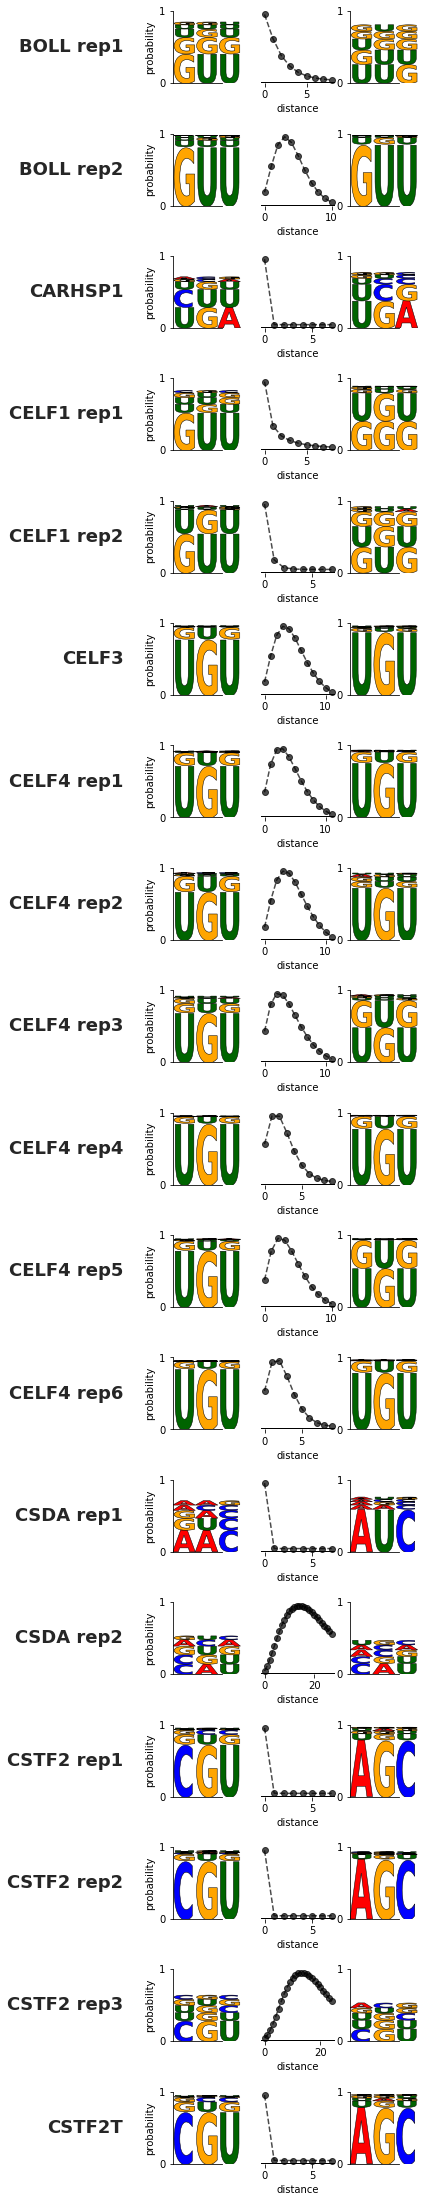

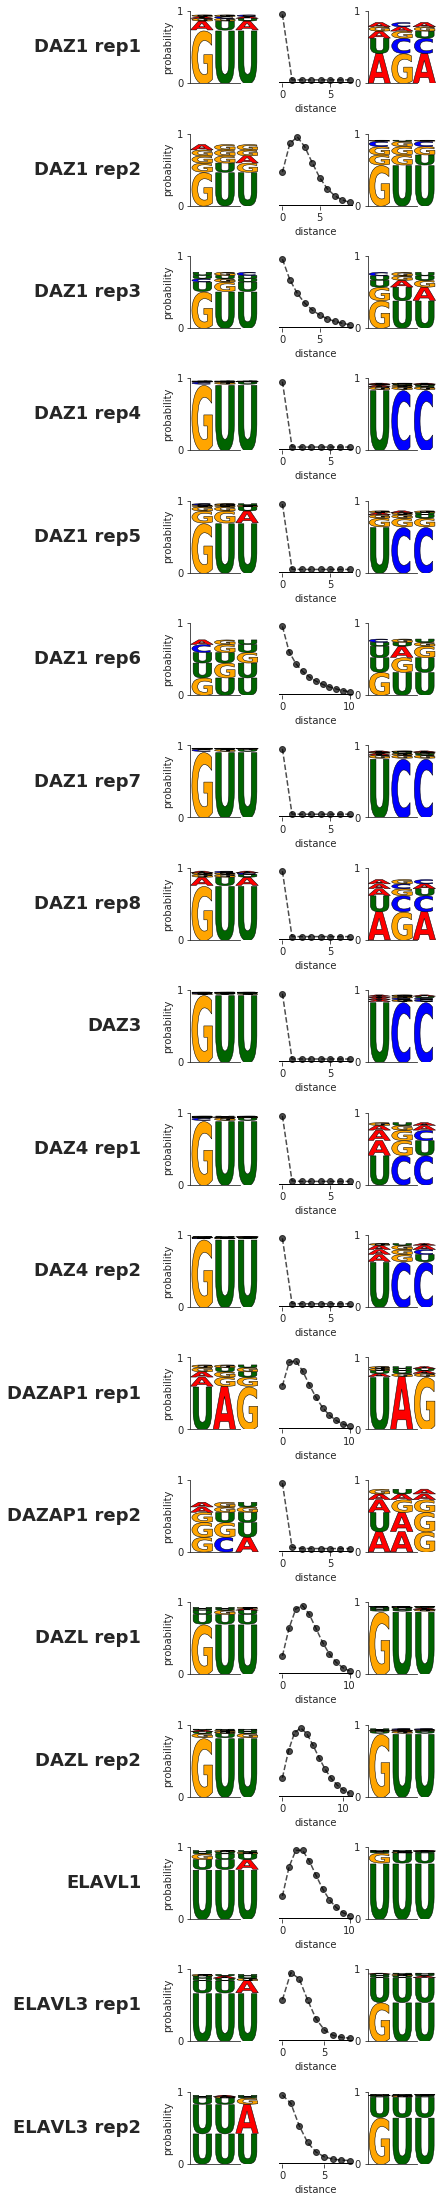

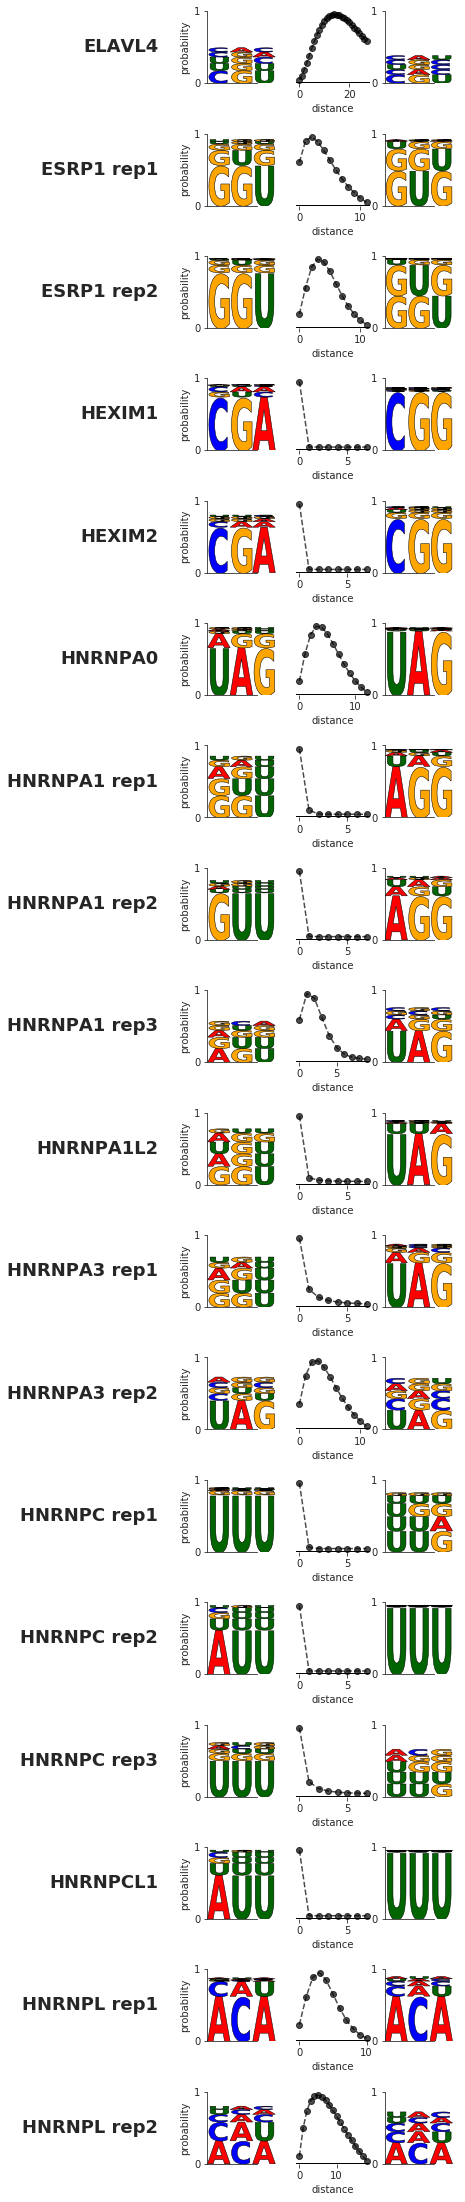

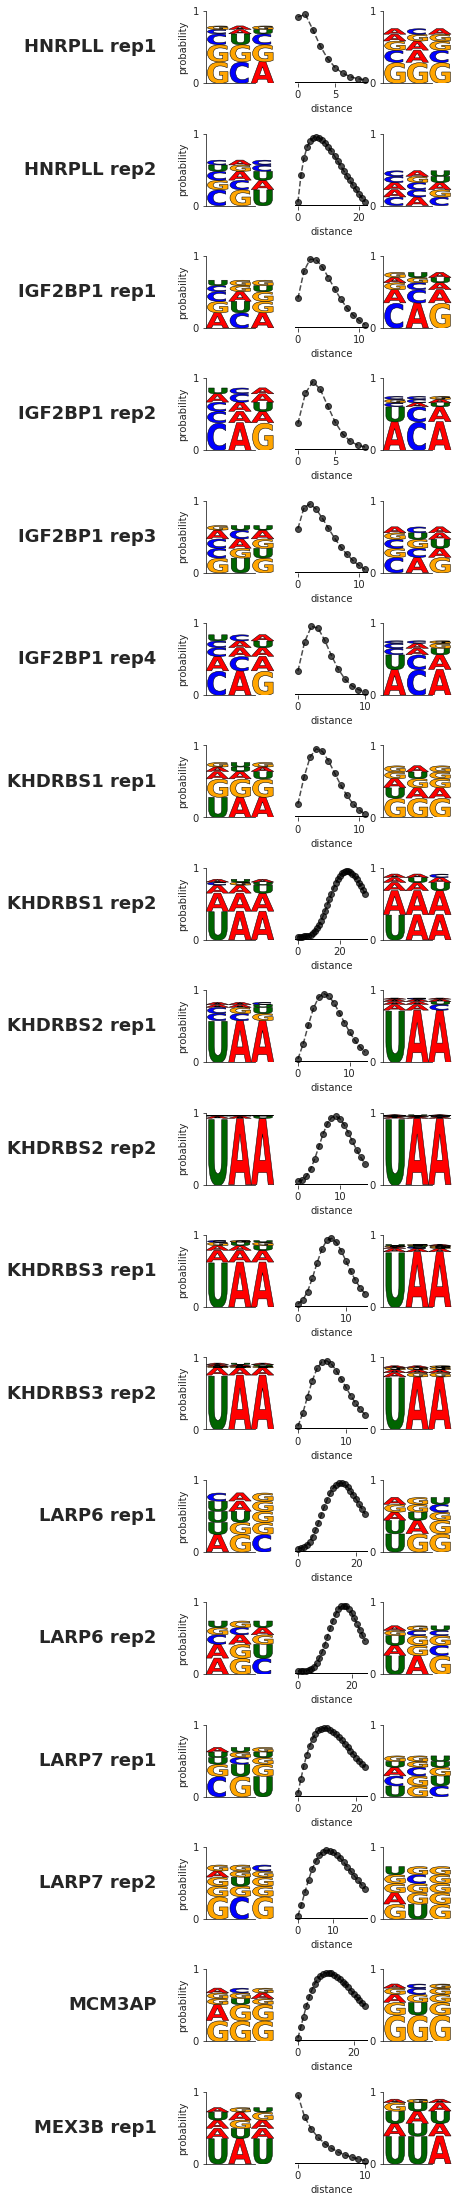

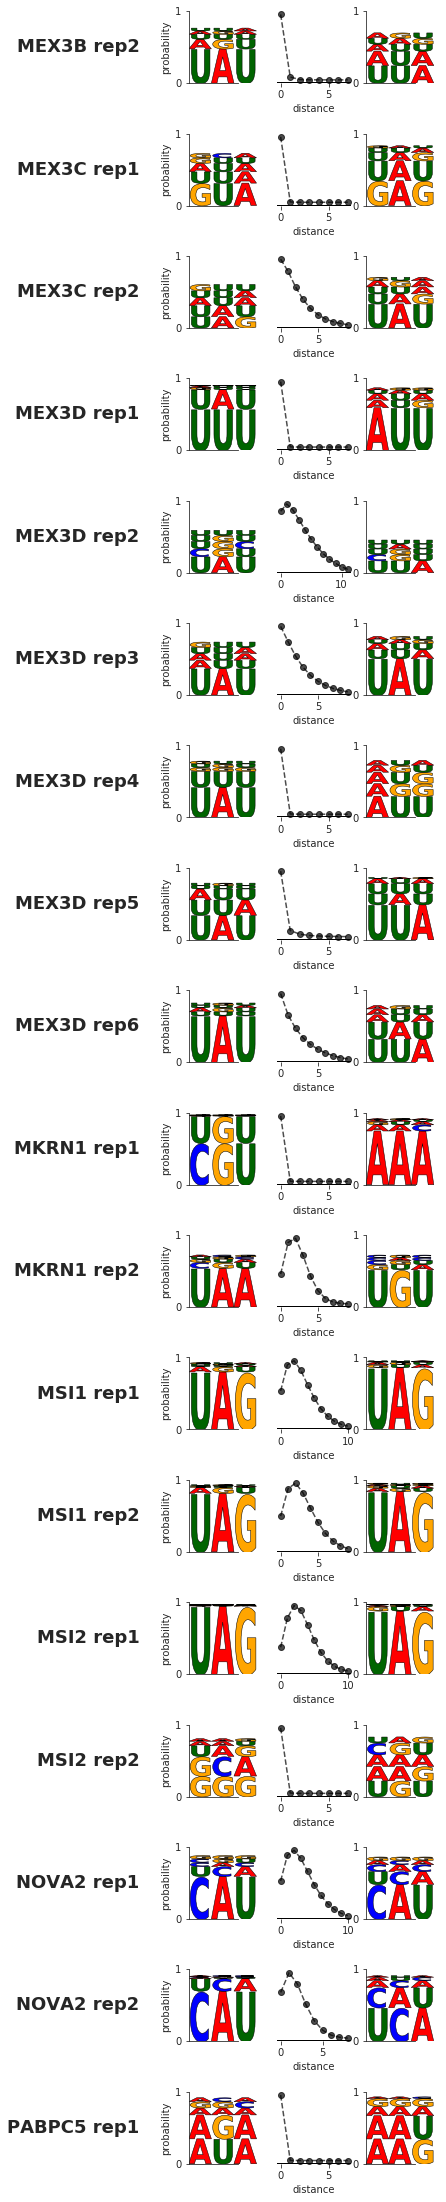

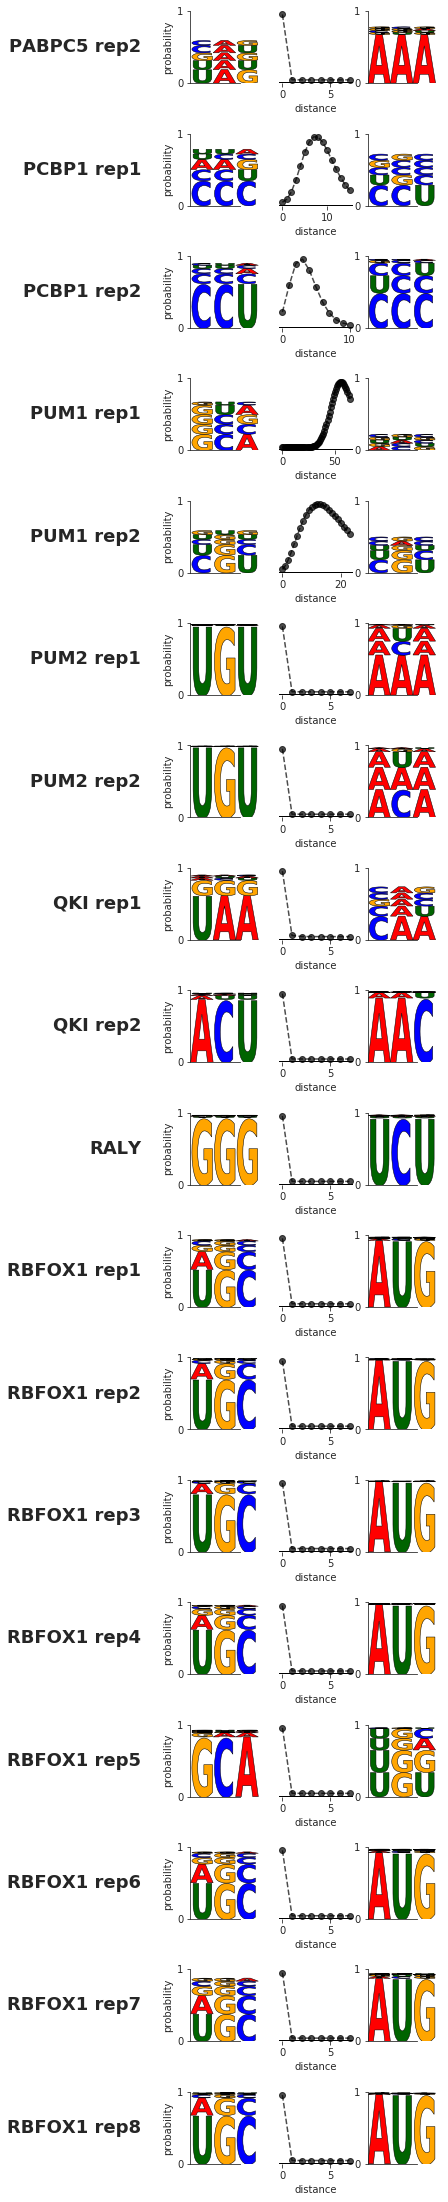

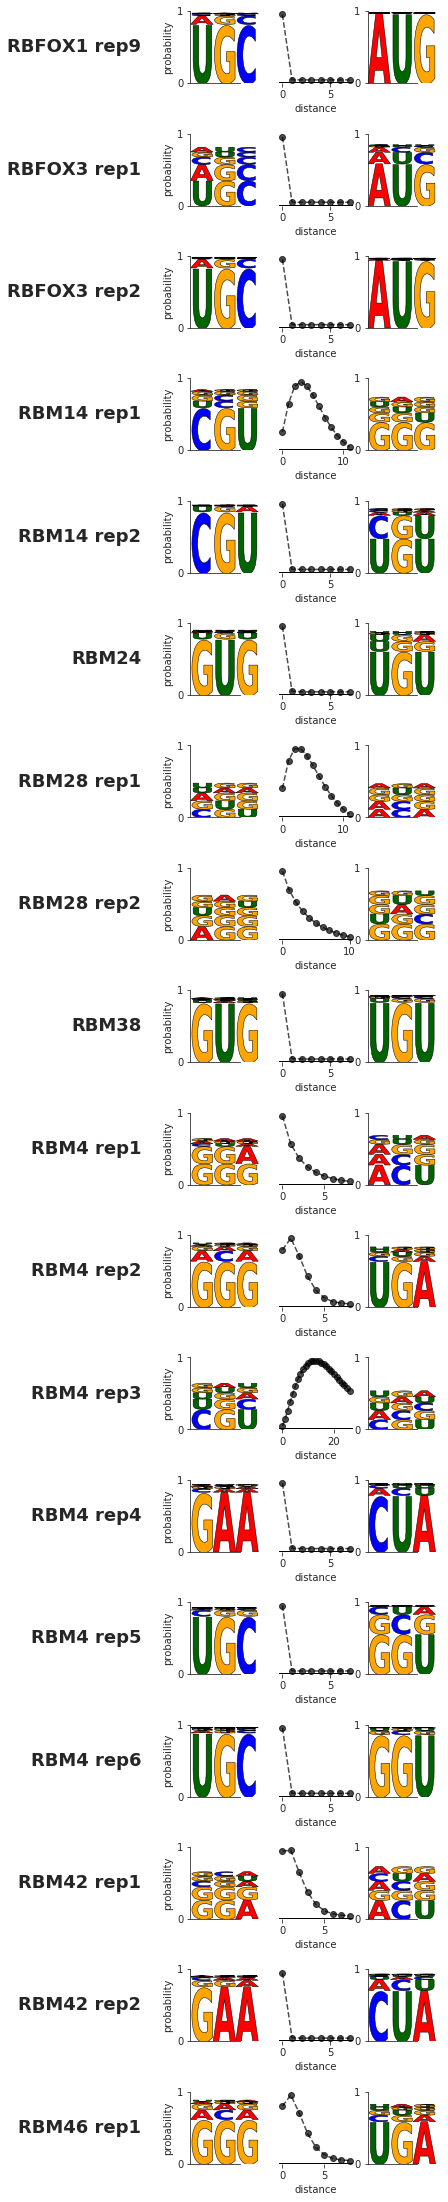

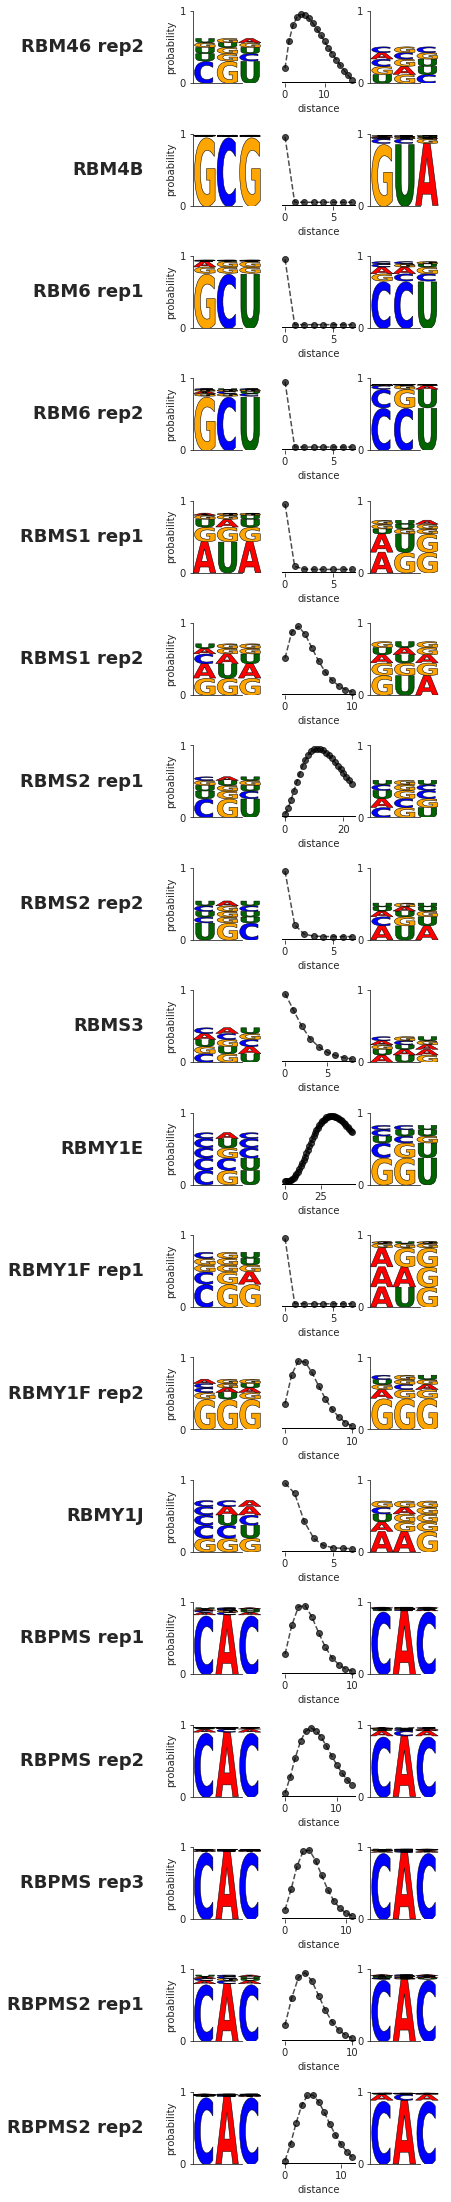

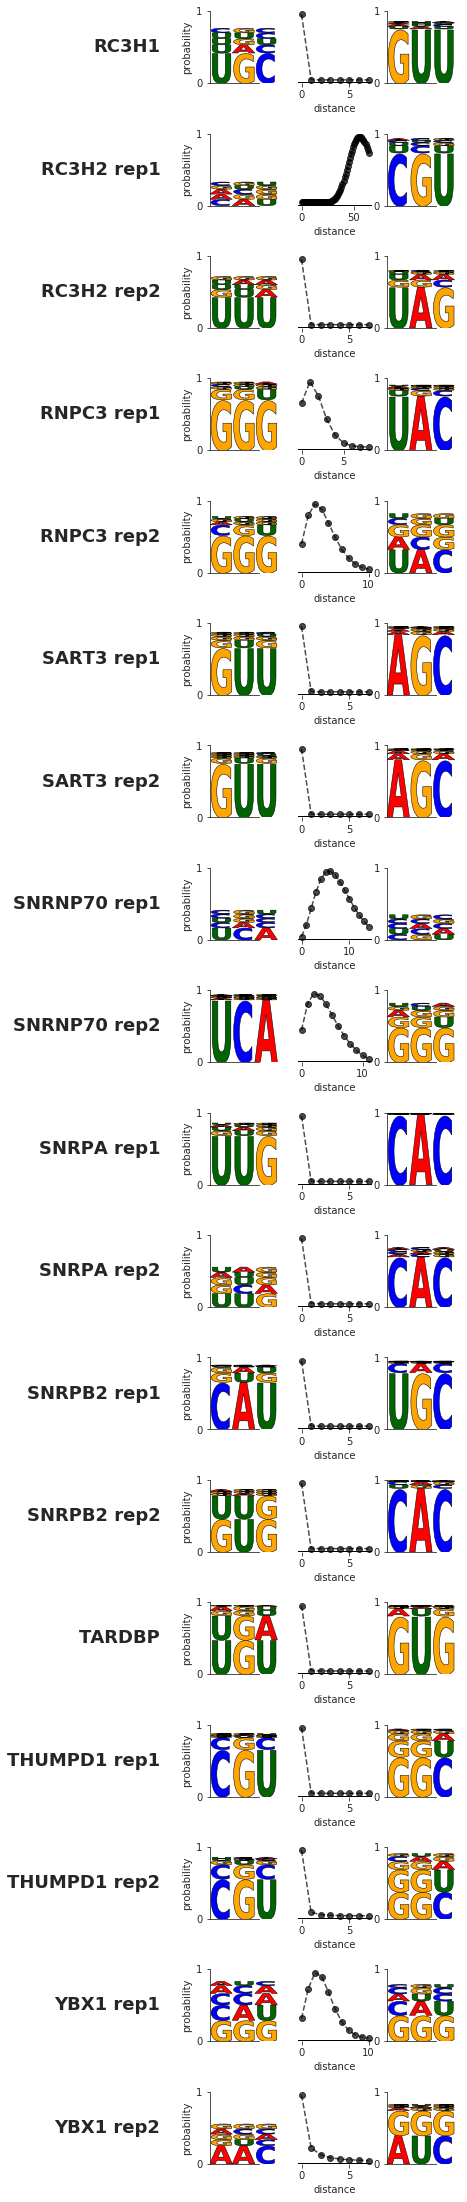

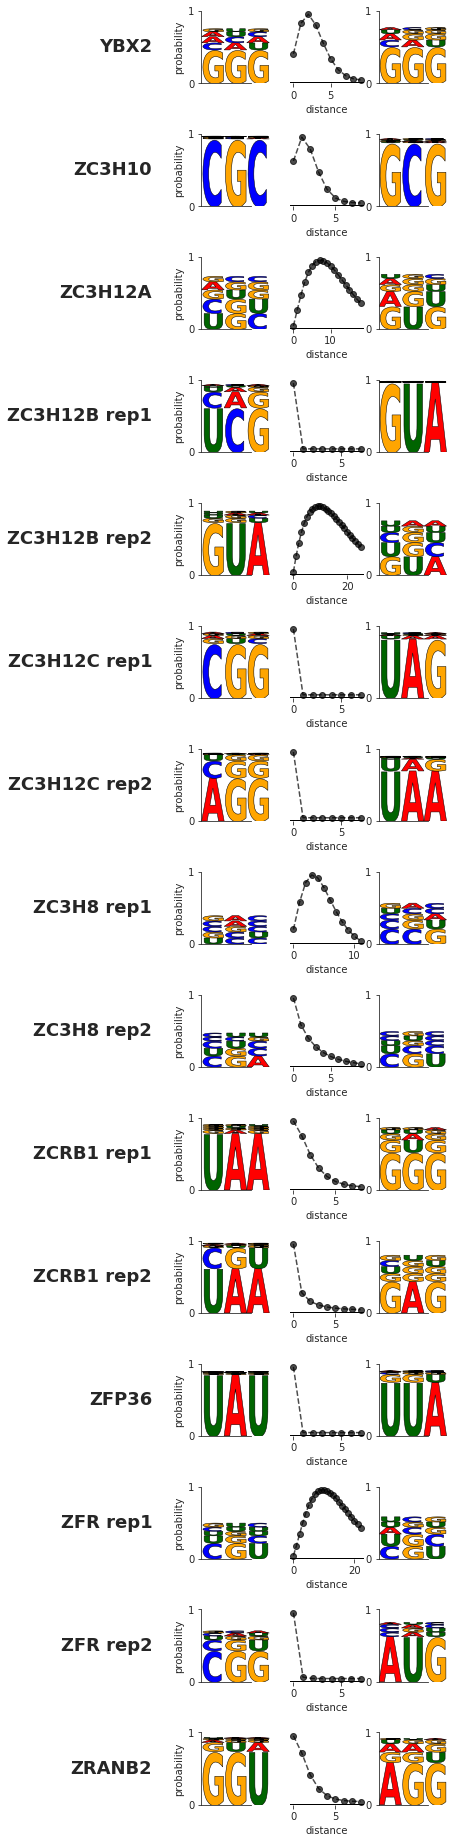

In [12]:
pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(plot_dir,f'HTSELEX_cs{k}_logos_by_pages.pdf'))

#include batch_size logos per pdf page
batch_size = 18

for i in range(int(len(factors_all)/batch_size)+1):
    start_ix = i*batch_size
    end_ix = min((i+1)*batch_size, len(factors_all))
    
    sub_factors = factors_all[start_ix:end_ix]
    sub_names = new_names[start_ix:end_ix]
    
    fig, axes = plt.subplots(len(sub_factors),3, figsize=(4.5, len(sub_factors)*2.2))
    plt.subplots_adjust(hspace=0.7)

    plot_logos(sub_factors, 
               param_dir, 
               file_name=os.path.join(plot_dir, f'x.pdf'), 
               figwidth=6, 
               new_names=sub_names)
    pdf.savefig(fig, bbox_inches='tight')
pdf.close()

## distance distributions

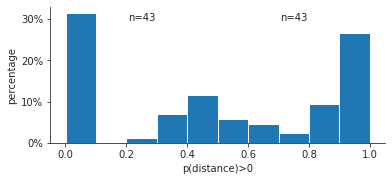

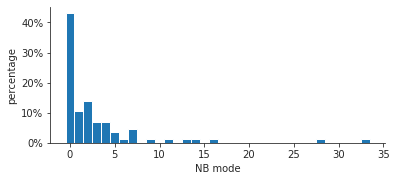

In [13]:
plot_dist_attributes(factors_all, 
                     param_dir, 
                     plot_name=os.path.join(plot_dir, f'HTSELEX_cs{k}_distance_attributes.pdf'))

## motif similarity

43 are bipartite
43 are monopartite


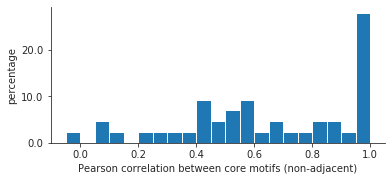

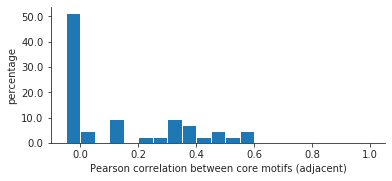

In [14]:
p_distanced_byfactor, pearson_byfactor = plot_motif_similarities(factors_all,
                        param_dir, 
                        plot_name=os.path.join(plot_dir, f'HTSELEX_cs{k}_motif_similarities.pdf'))

## entropy

In [15]:
def plot_motif_entropy(factors_all,param_dir, plot_name, figsize=(6,2.5), top_n=3):
    
    '''
    compare entropy values of BMF models in the HTR-SELEX dataset
    '''
    entropy_values = []
    probs_list = []
    for keyw in factors_all:  #the keyword which assigns the files to a batch
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        
        core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
        core1 = np.exp(-core1)
        topn_1 = core1.sort_values()[-top_n:]
        probs_list.append(topn_1.values)
        
        core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
        core2 = np.exp(-core2)
        topn_2 = core2.sort_values()[-top_n:]
        probs_list.append(topn_2.values)
        
        
        base_counts = np.zeros(4)
        base_dict = {'A':0,'C':1,'G':2,'U':3}
        
        for i in range(top_n):
            kmer1 = topn_1.index[i]
            prob1 = topn_1.values[i]
            kmer2 = topn_2.index[i]
            prob2 = topn_2.values[i]
            
            for i in range(len(kmer1)):
                base_counts[base_dict[kmer1[i]]] += prob1
                base_counts[base_dict[kmer2[i]]] += prob2
                
        probs = base_counts/np.sum(base_counts)
        entropy = 0
        for prob in probs:
            if prob>0:
                entropy -= prob*np.log2(prob)
        entropy_values.append(entropy)

    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)
    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(1 - nbinom.cdf(0, r, p))

    factors = [f.split('-')[0] for f in factors_all]

    #make a dataframe and split it based on ids
    df = pd.DataFrame({'probs':p_distanced, 'entropy_values':entropy_values, 'factors':factors}) 

    entropy_onecore = []
    entropy_bipartite = []
    entropy_all = {}
    factors_prob = {}
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        final_prob = df.loc[:,'probs'].mean()
        entropy_all[identifier] = df.loc[:,'entropy_values'].mean()
        factors_prob[identifier] = final_prob
        if final_prob>0.5:
            entropy_bipartite.append(df.loc[:,'entropy_values'].mean())
        else:
            entropy_onecore.append(df.loc[:,'entropy_values'].mean())

            
    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_name)
                                                 
    #plot the entropy_values between domains that are distanced
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(entropy_bipartite, 
            bins=np.arange(0,2.1,0.1), 
            density=True)
    _,ymax = ax.get_ylim()
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    

    _ = ax.set_xlabel('entropy (high distance)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.locator_params(axis='y', nbins=4)

    pdf.savefig(fig, bbox_inches='tight')

    #plot the entropy correlation when on big motif is learnt
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(entropy_onecore, 
            bins=np.arange(0,2.1,0.1), 
            density=True)
    ax.set_ylim(0,ymax)
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    _ = ax.set_xlabel('entropy (low distance)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    
    return (entropy_bipartite, entropy_onecore, entropy_all, factors_prob, probs_list)

In [16]:
def generate_entropy(probs_list, k=3):
    
    '''
    generate a synthetic BMF motif model and return its entropy
    '''
    
    base_counts = np.zeros(4)
    base_dict = {'A':0,'C':1,'G':2,'U':3}
    
    base_counts = np.zeros(4)
    kmers = list(kmer_inx.keys())

    topn_1 = random.sample(kmers,len(kmers))
    topn_2 = random.sample(kmers,len(kmers))
    
    probs1 = random.choice(probs_list)
    probs2 = random.choice(probs_list)
    
    for i in range(len(kmers)):
        kmer1 = topn_1[i]
        prob1 = probs1[i]
        kmer2 = topn_2[i]
        prob2 = probs2[i]

        for i in range(len(kmer1)):
            base_counts[base_dict[kmer1[i]]] += prob1
            base_counts[base_dict[kmer2[i]]] += prob2

    probs = base_counts/np.sum(base_counts)
    entropy = 0
    for prob in probs:
        if prob>0:
            entropy -= prob*np.log2(prob)
            
    return entropy

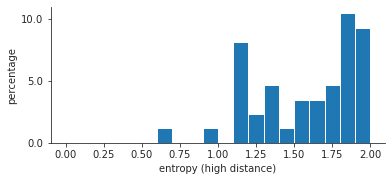

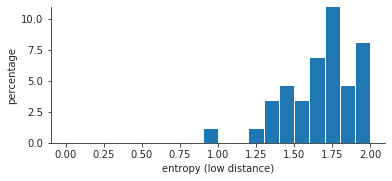

In [17]:
entropy_bipartite, entropy_onecore, entropy_all, factors_prob, probs_list = plot_motif_entropy(factors_all,
                    param_dir, 
                    plot_name=os.path.join(plot_dir, f'HTSELEX_cs{k}_enthropies.pdf'),
                    top_n=4**k
                   )

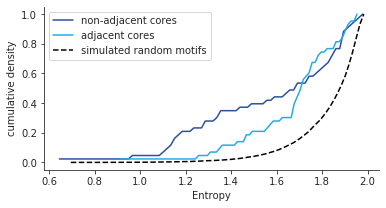

In [18]:
random_enthropies = [generate_entropy(probs_list) for i in range(10000)]
fig,ax = plt.subplots(figsize=(6,3))

values, base = np.histogram(entropy_bipartite, bins=80)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(entropy_bipartite)
# plot the cumulative function
ax.plot(base[:-1], cumulative, c='#2B4FA2', label='non-adjacent cores')

values, base = np.histogram(entropy_onecore, bins=80)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(entropy_onecore)
# plot the cumulative function
ax.plot(base[:-1], cumulative, c='#27AAE1', label='adjacent cores')

values, base = np.histogram(random_enthropies, bins=80)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(random_enthropies)
# plot the cumulative function
ax.plot(base[:-1], cumulative, ls='--', c='black', label='simulated random motifs')

_ = ax.set_xlabel('Entropy')
_ = ax.set_ylabel('cumulative density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(plot_dir, f'HTSELEX_cs{k}_entropy_cdp.pdf'), bbox_inches='tight')

## repetitiveness

In [19]:
def get_max_prob(core1, core2):
    max_prob = 0
    n = ['A','C','G','U']
    for base1, base2 in list(itertools.product(n, repeat=2)):
        if base1 != base2:
            prob_a = core1.at[base1+base2+base1] + core1.at[base2+base1+base2]
            prob_b = core2.at[base1+base2+base1] + core2.at[base2+base1+base2]
        else:
            prob_a = core1.at[base1+base2+base1]
            prob_b = core2.at[base1+base2+base1]
        if (prob_a*prob_b) > max_prob:
            max_prob = prob_a*prob_b
    return np.sqrt(max_prob)

In [20]:
def plot_motif_repetition(factors_all,param_dir, plot_name, figsize=(6,2.5), top_n=3):
    '''
    compare repetitiveness values of BMF models in the HTR-SELEX dataset
    '''
    repetitive_scores = []
    probs_list = []
    for keyw in factors_all:  #the keyword which assigns the files to a batch
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        
        core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
        core1 = np.exp(-core1)
        core1 = core1/np.sum(core1)

        core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
        core2 = np.exp(-core2)
        core2 = core2/np.sum(core2)
        
        probs_list.append(core1.values)
        probs_list.append(core2.values)
        
        
        max_prob = get_max_prob(core1, core2)
        repetitive_scores.append(max_prob)

    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)
    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(1 - nbinom.cdf(0, r, p))

    factors = [f.split('-')[0] for f in factors_all]

    #make a dataframe and split it based on ids
    df = pd.DataFrame({'probs':p_distanced, 'repetitive_score':repetitive_scores, 'factors':factors}) 

    repetitive_onecore = []
    repetitive_bipartite = []
    repetitive_all = {}
    factors_prob = {}
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        final_prob = df.loc[:,'probs'].mean()
        repetitive_all[identifier] = df.loc[:,'repetitive_score'].mean()
        factors_prob[identifier] = final_prob
        if final_prob>0.5:
            repetitive_bipartite.append(df.loc[:,'repetitive_score'].mean())
        else:
            repetitive_onecore.append(df.loc[:,'repetitive_score'].mean())

            
    pdf = matplotlib.backends.backend_pdf.PdfPages(plot_name)
                                                 
    #plot the values between domains that are distanced
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(repetitive_bipartite,  
            density=True)
    _,ymax = ax.get_ylim()
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    

    _ = ax.set_xlabel('Repetitiveness (high distance)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    plt.locator_params(axis='y', nbins=4)

    pdf.savefig(fig, bbox_inches='tight')

    #plot the Repetitiveness when a large motif is learnt
    fig,ax = plt.subplots(figsize=(6,2.5))

    n,*_ = ax.hist(repetitive_onecore,  
            density=True)
    ax.set_ylim(0,ymax)
    formatter = mticker.FuncFormatter(lambda v, pos: str(v * 5))
    plt.gca().yaxis.set_major_formatter(formatter)
    
    _ = ax.set_xlabel('Repetitiveness (low distance)')
    _ = ax.set_ylabel('percentage')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    
    return (repetitive_bipartite, repetitive_onecore, repetitive_all, factors_prob, probs_list)

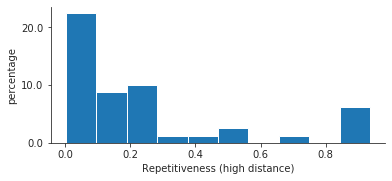

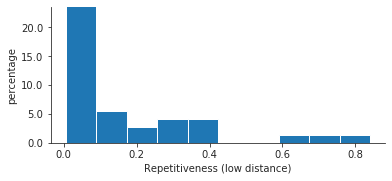

In [21]:
repetitive_bipartite, repetitive_onecore, repetitive_all, factors_prob, probs_list = plot_motif_repetition(factors_all,
                    param_dir, 
                    plot_name=os.path.join(plot_dir, f'HTSELEX_cs{k}_repetitiveness.pdf'),
                    top_n=4**k
                   )

In [22]:
def generate_repetitiveness(probs_list, k=3):
    
    '''
    generate a synthetic BMF motif model and return its repetitiveness
    '''
    
    base_counts = np.zeros(4)
    base_dict = {'A':0,'C':1,'G':2,'U':3}
    
    base_counts = np.zeros(4)
    kmers = list(kmer_inx.keys())

    topn_1 = random.sample(kmers,len(kmers))
    topn_2 = random.sample(kmers,len(kmers))
    
    probs1 = random.choice(probs_list)
    probs2 = random.choice(probs_list)
    
    core1 = pd.Series({a:b for a,b in zip(topn_1,probs1)})
    core2 = pd.Series({a:b for a,b in zip(topn_2,probs2)})
    
    max_prob = get_max_prob(core1, core2)
            
    return max_prob

random_enthropies = [generate_repetitiveness(probs_list) for i in range(10000)]

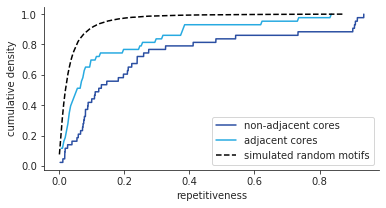

In [23]:
fig,ax = plt.subplots(figsize=(6,3))

values, base = np.histogram(repetitive_bipartite, bins=5000)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(repetitive_bipartite)
# plot the cumulative function
ax.plot(base[:-1], cumulative, c='#2B4FA2', label='non-adjacent cores')

values, base = np.histogram(repetitive_onecore, bins=200)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(repetitive_onecore)
# plot the cumulative function
ax.plot(base[:-1], cumulative, c='#27AAE1', label='adjacent cores')

values, base = np.histogram(random_enthropies, bins=200)
#evaluate the cumulative
cumulative = np.cumsum(values)/len(random_enthropies)
# plot the cumulative function
ax.plot(base[:-1], cumulative, ls='--', c='black', label='simulated random motifs')

_ = ax.set_xlabel('repetitiveness')
_ = ax.set_ylabel('cumulative density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()
plt.savefig(os.path.join(plot_dir, f'HTSELEX_cs{k}_repetitiveness_cdp.pdf'), bbox_inches='tight')

## clustering BMF models based on their sequence similarities by tSNE

In [24]:
def probs_matrix(factors_all, param_dir):
    
    '''
    construct a matrix of k-mer probabilities for all RBPs in the HTR-SELEX dataset
    '''
    
    probs = []
    for keyw in factors_all:  #the keyword which assigns the files to a batch
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files)


        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        core1 = data.sort_values(by='LL').iloc[0,:len(kmer_inx)]
        core1 = np.exp(-core1.values)
        core2 = data.sort_values(by='LL').iloc[0,len(kmer_inx):2*len(kmer_inx)]
        core2 = np.exp(-core2.values)

        probs.append(np.hstack([core1,core2]))
    
    #make a dataframe and split it based on ids
    factors = [f.split('-')[0] for f in factors_all]
    df = pd.DataFrame({'probs':probs, 'factors':factors}) 

    probs_byfactor = []
    factors = []
    for identifier, df_sub in df.groupby('factors'):
        #keep the max value in each split
        factor_prob = np.mean([probs for probs in df_sub.loc[:,'probs']], axis=0)

        factors.append(identifier)
        probs_byfactor.append(factor_prob)
    
    return factors, np.array(probs_byfactor)

In [25]:
from sklearn.preprocessing import normalize
from sklearn import manifold
import matplotlib

factors, probs_byfactor = probs_matrix(factors_all, param_dir)

pearson_corr = [[pearsonr(probs_byfactor[i,:], probs_byfactor[j,:])[0] for j in range(probs_byfactor.shape[0])] for i in range(probs_byfactor.shape[0])]
pearson_corr = np.array(pearson_corr)

cmap = matplotlib.cm.get_cmap('coolwarm')
col_values = []
for factor in factors:
    col_values.append(factors_prob[factor])
col_values = (col_values-min(col_values))/(max(col_values)-min(col_values))
colors = [cmap(c) for c in col_values]

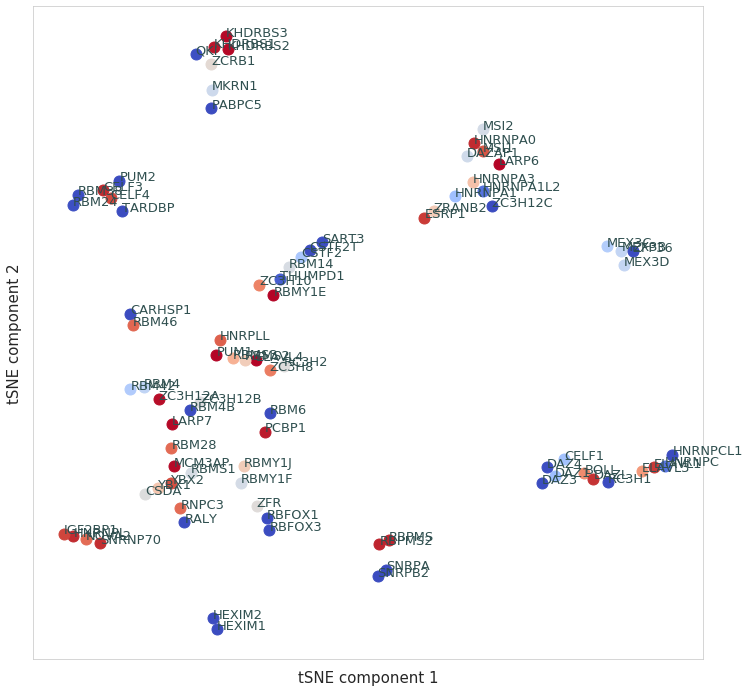

In [26]:
sns.set_style("whitegrid", {'axes.grid' : False})

for j in range(0, 1):
    
    np.random.seed(j)
    init=np.random.rand(probs_byfactor.shape[0],2)
    
    per=3.5
    
    model = manifold.TSNE(n_components=2, metric='precomputed', perplexity=per, n_iter = 8000, init=init)
    coords = model.fit_transform(1 - pearson_corr)

    fig, ax = plt.subplots(facecolor='w')
    fig.set_size_inches(12,12)

    for i, text in enumerate(factors):
        x = coords[i][0]
        y = coords[i][1]
        plt.plot(x, y,  color=colors[i], marker='o', markersize=11)
        plt.text(x,y , text , fontsize=13, color='#2F4F4F')

    ax.xaxis.set_ticklabels([])   
    ax.yaxis.set_ticklabels([])
    
    ax.set_xlabel('tSNE component 1', fontsize=15)
    ax.set_ylabel('tSNE component 2', fontsize=15)
    
    plt.savefig(os.path.join(plot_dir, f'tSNE_{j}.pdf'), bbox_inches='tight')